This notebook explores the basics of Reinforcement learning after attending the RL workshop

First the recommended How to apply? [Tabular Q-learning with Gym tutorial](https://towardsdatascience.com/reinforcement-learning-with-openai-d445c2c687d2) is followed.  
NOTE: This blog post is not followed exactly, as it leaves out some very usefull information, has outdated code examples, and performs some very situationally dependant actions which does not work well when copying the steps taken over

Lets view all our installed environments

In [6]:
from gym import envs 
print(envs.registry.keys())

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4'])


Next lets render an environment, and perform random actions by sampling a random action from the action space, then the given action is perfomed within the environment.  
Performing actions within the environment returns information about the action and environment including a terminated value, when this is True the model has been able to complete the environment goal.

In [15]:
import gym
env = gym.make('MountainCarContinuous-v0')
observation = env.reset()
i = 0
while True:
    i += 1
    env.render()
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated:
        print("Finished after {} timesteps".format(i+1))
        break

c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\classic_control\continuous_mountain_car.py:193: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


Finished after 3259 timesteps


In [17]:
env = gym.make('MountainCarContinuous-v0')
print(env.action_space) #[Output: ] Box(1,)
print(env.observation_space) #[Output: ] Box(2,)

Box(-1.0, 1.0, (1,), float32)
Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


The MountainCarContinuous-v0 has a single action space value, indicating the force applied in the x-axis (negative being left and positive being right),
while the observation space shows two values, which to my knowledge indicate the position and velocity
documentation on [this env](https://mgoulao.github.io/gym-docs/environments/classic_control/mountain_car_continuous/#observation-space)

Next lets start working within the FrozenLake environment, for this additional environments had to be installed, which would have caused issues with box2d-py, but thankfully I have an older version of pip which still supports the legacy installer allowing me to install it via there automatically (pip=23.0.1, legacy installer no longer supported from pip=23.1)

Frozen lake is an environment which a 2d grid, on this grid there is a goal space, and some danger spaces that the actor has to navigate through.  
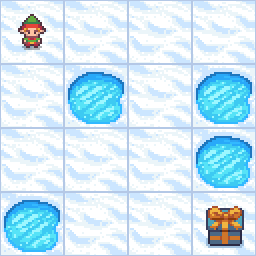

The first step of the model will be the Q-table, this table contains the actions for a given state whith the rewards that action is expected to give (this can also be seen as a representation for the quality of an action), this table will start off with random values, and through iterating over the environment, the Q-table can be refined based on the findings.

In [45]:
import gym
import numpy as np
env = gym.make('FrozenLake-v1', render_mode='rgb_array', map_name='4x4') # Frozen lake of 4x4 size <- human renderer shows game visually in pop_up, but ruins performance
Q = np.zeros([env.observation_space.n, env.action_space.n]) # env.observation.n, env.action_space.n gives number of states and action in env loaded
# The table will look something like
# | State | Action: Up | Action: Down | Action: Left | Action: Right |
# |-------|------------|--------------|--------------|---------------|
# |   0   |   0.2      |   0.1        |   0.3        |   0.5         |
# | etc.                                                             |

# Set the hyper parameters
eta = .628 # Learning rate
gma = .9 # discount factor, determining how far in the future the agent should consider
iterations = 1000000 # amount of "episodes, or iterations of the model

total_rewards = []
total_steps = []
success_rate = []
for i in range(iterations):
    state = env.reset()[0] # Setup a fresh environment
    episode_reward = 0
    step = 0
    while True: # Start stepping through the environment to obtain Q values to help improve the table
        step += 1
        # env.render()
        # action = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i+1))) # Choose a random action from the Q table
        # A random action is obtained greedily, by first getting all actions within the current state, 
        # Obtain a list of random indexes within the possible range of actions <- this adds the exploration, so that the model does not get stuck in a local minimum of highest reward
        # next this value is multiplied by a decreasing value based on episode count, thereby reducing the amount of exploration as the training continues
        # lastyle, the greediest action is chosen from the adjusted list of actions based on highest reward 
        
        # to make this more readable I have changed it to a conditional function instead
        explorationChance = 1.0 / (i + 1)
        if np.random.rand() < explorationChance:
            action = env.action_space.sample() # Explore, by getting a random action
        else:
            action = np.argmax(Q[state, :]) # Exploit, by getting the best action

        # Get new state & reward from environment
        observation, reward, terminated, truncated, info = env.step(action) # perform the action
        Q[state, action] = Q[state, action] + eta*(reward + gma*np.max(Q[observation,:]) - Q[state, action]) # Update Q-Table with the action result
        # The new reward for given state and action is calculated by first, calculate the maxiumum expected reward from given action, taking into account future actions (based on gma)
        # This maximum possible value is then subtracted from with the current value, to get the possible gain
        # then the possible gain is added to the current value, reducing the possible gain first by eta
        episode_reward += reward
        state = observation # Update the state for next step
        if terminated:
            break # Environment was terminated, either by reaching the goal or falling in a hole

    total_rewards.append(episode_reward)
    total_steps.append(step)
    success_rate.append(int(episode_reward > 0))
    # env.render()
env.close()
print(f"Success rate (%) over {iterations} episodes: {str(np.mean(success_rate) * 100)}")

Success rate (%) over 1000000 episodes: 0.0


Above I have set-up a Q-table learning model that will step through the frozen lake environment and update the Q-table based on the rewards gained, this model is very slow at learning however due to the agent only getting a reward when reaching the goal, which can take 100s if not 1000s of iterations before even reaching it once.  
When training the model with 100.000 episodes, only sometimes would there be even a single successful episode, while with 1 million episodes it was still at 0 D:

Below a plot of the rewards over the episodes

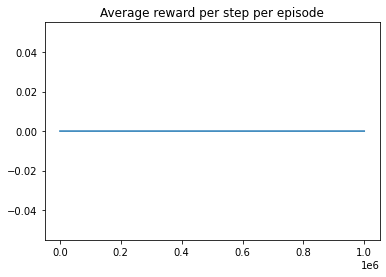

In [47]:
import matplotlib.pyplot as plt

average_reward_per_step = [reward / steps for reward, steps in zip(total_rewards, total_steps)]

plt.plot(average_reward_per_step)
plt.title("Average reward per step per episode")

plt.show()

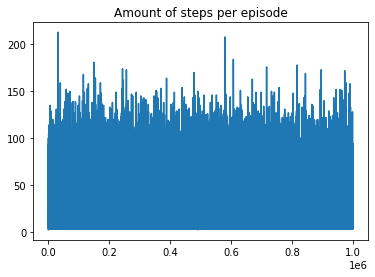

In [48]:
plt.plot(total_steps)
plt.title("Amount of steps per episode")

plt.show()

The agent is really just walking around for 100-200 steps, just to fall in a hole for a million times... (did I put this model in AI hell?)

**Emeregency close of any running environment if code cell is interrupted, as otherwise it will kill the python kernel**

In [123]:
env.close()

: 

Next I will be looking at the [Keras ANN Q-learning example](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c)

In [4]:
import gym
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from collections import deque

First lets create a class that holds all of the required DQN definitions

In [1]:
class DQN:
    def __init__(self, env):
        self.env = env # gym environment
        self.memory = deque(maxlen=2000) # maximum memory of 2000, a random selection will be made of the memory when evaluating actions
        
        self.gamma = 0.85 # future discount factor
        self.epsilon = 1.0 # exploration vs exploitation
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.eta = 0.005 # learning rate
        self.tau = .125 # model weight adjustment rate for target model
        self.history_batch_size = 8 # Amount of history states to replay

        self.model = self.create_model() # The model used for training and is updated rapidly
        self.target_model = self.create_model() # The model t|hat updates less often, used to give actions to the current episode

    def create_model(self):
        # Create the ANN model that will handle the action choice 
        model = Sequential()
        state_shape = self.env.observation_space.shape
        model.add(Dense(24, input_dim=state_shape[0], activation="relu"))
        model.add(Dense(48, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=self.eta))
        return model

    def action(self, state):
        # Choose an action to take from the more stable weighted model
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample() # Exlore a random action
        return np.argmax(self.model.predict(np.array(state, dtype=np.float32), verbose=0)[0]) # Greedily select action

    def remember(self, state, action, reward, new_state, done):
        # Add action results to the model memory
        self.memory.append([np.array(state, dtype=np.float32), action, reward, new_state, done])

    def replay(self):
        # Attempt to improve weights of model by replaying the model's memory (this is scarily similar to what is presumed to happen during REM sleep...)
        if len(self.memory) < self.history_batch_size: 
            return

        samples = random.sample(self.memory, self.history_batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state, verbose=0)
            if done:
                target[0][action] = reward # If state is terminated, set the Q-value to be the reward value
            else:
                Q_future = max(self.target_model.predict(new_state, verbose=0)[0]) # Calculate the Q-value based on future steps
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)

    def target_train(self):
        # Update the weights of the action giving model,
        # This model's weights are adjusted less often to reduce the amount of entropy experienced when having a model predict actions with rapidly changing weights
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)


In [5]:
env = gym.make("MountainCar-v0")
episodes = 5
max_steps = 100

total_steps = []

agent = DQN(env=env)
for episode in range(episodes):
    print(f"episode: {episode}")
    cur_state = [list(env.reset()[0])] # Get initial state of the reset environment
    first_step = True
    for step in range(max_steps):
        action = agent.action(cur_state) # Get action for current state
        new_state, reward, terminated, truncated, debug = env.step(action) # Perform the action
        new_state = new_state.reshape(1,2)
            
        agent.remember(cur_state, action, reward, new_state, terminated) # Store the performed action for given state and result in models memory
        
        agent.replay() # replay the memory of the model to adjust Q-table (weights) <- this kills performance
        agent.target_train() # adjust the target Q-table based on difference and learning rate of the two model's weights

        cur_state = new_state
        if terminated:
            total_steps.append(step)
            break # environment terminated

2023-10-25 23:54:30.424642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 23:54:30.449351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 23:54:30.449392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 23:54:30.451983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 23:54:30.452025: I tensorflow/compile

episode: 0


2023-10-25 23:54:31.612093: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-25 23:54:32.751144: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa1a0005fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-25 23:54:32.751192: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-10-25 23:54:32.758386: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-25 23:54:32.783397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-25 23:54:32.879733: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


episode: 1
episode: 2
episode: 3
episode: 4


Lets implement GPU support for tensorflow, because the constant training of the ANN is making the model extremely slow (15 minutes+ per episode)

In [1]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [2]:
tf.config.list_physical_devices('GPU')

[]

As you can see, right now I have v 2.14.0 of tensorflow, and there are no avaible GPUs, while I do have a GTX 1070 in this PC,  
the GTX 1070 (unlike my GTX 1650 in my laptop D:) is CUDA-Enabled according to the [NVidia support list](https://developer.nvidia.com/cuda-gpus), also make sure the newest drivers for the given graphics card are installed (I have already done this, as it is generally best practise to keep them up-to-date).  
   
Next, install the [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive) in accordance to the version [supported by tensorflow](https://www.tensorflow.org/install/source) which in this case is 11.8,  
   
and lastly install the [cuDNN SDK](https://developer.nvidia.com/cudnn) which will extend the CUDA Toolkit, once again make sure it is the version that the installed tensorflow version supports. (After downloading the SDK, move the files into the toolkit directory which after some looking around turned out to be here: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8).

Now that the windows GPU side is done, lets set-up WSL2, as TF>2.18 no longer has native windows support >:(  
First step will be to install [WSL2](https://learn.microsoft.com/en-us/windows/wsl/install) thankfully I have already done that.  
  
Next setup GPU support in WSL2, this can best be done via the [NVidia getting started guide](https://docs.nvidia.com/cuda/wsl-user-guide/index.html#getting-started-with-cuda-on-wsl-2), via this guide the CUDA toolkit will also be installed on the WSL2 client for the specific GPU.  
(NOTE: Make sure to install cuda toolkit version has mentioned before (11.8) as the guide might not indicate the correct version!!!)
  
After this, pip and tensorflow can be installed (make sure that when you try to access the wsl, you have the correct distro selected as for me it kept giving errors due to my Docker instance being set as the default).

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-10-25 23:23:42.732993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 23:23:42.733047: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 23:23:42.733068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 23:23:42.738794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 23:23:44.494920: I tensorflow/compiler/

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

So 'Technically' yes, I am now running the notebook through WSL2 with TF able the access my GPU, however it throws a lot of warnings both in just this function example to check if it can find my GPU, and even more when modelling (most of these warnings seem to be about the kernel not supporting NUMA, which *should* be fine according to some discussion threads out there...).